# Setup

Importing libraries:

In [151]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    TunedThresholdClassifierCV,
    StratifiedKFold
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    PassiveAggressiveClassifier,
    Perceptron
)
from sklearn.metrics import (
    make_scorer, 
    fbeta_score, 
    recall_score,
    accuracy_score,
    confusion_matrix
)

Importing processed datasets:

In [152]:
DATA_DIR = '../Dataset/processed'

train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')

In [153]:
train.shape, test.shape

((9000, 14), (1000, 14))

# Data preparation

In [154]:
TARGET = 'Machine failure'

In [155]:
features = [f for f in train.columns if f != TARGET]

In [156]:
categorical_features = [
    'Type', 
    'temp_diff_above_threshold', 
    'power_out_of_range', 
    'strain_below_11k', 
    'strain_above_12k'
]

numerical_features = [f for f in features if f not in categorical_features]

In [157]:
reduced_features = [f for f in features if f not in 
                    ('Type', 'air_temp_celsius', 'process_temp_celsius', 'power')]

# Modeling framework

* **Metric**: F-beta score  
    * Weighted harmonic mean of precision and recall.  
    * We will apply beta=2 to make recall twice as important as precision.

* **Model pipeline**:  
    * Feature scaling - standardization (StandardScaler)  
    * Classifiers - Logistic regression, Ridge classifier, Passive-Aggressive classifier, Perceptron
    * Hyperparameters can be tested manually due to relatively small dataset. 

* **Threshold tuning**: 
    * TunedThresholdClassifierCV (for cross-validation + thresholding)
    * StratifiedKFold as cross-validation scheme

In [158]:
def fit_model(classifier, feature_set):
    fbeta = make_scorer(fbeta_score, beta=2)
    skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=0)

    scaler = StandardScaler()
    model_pipeline = make_pipeline(scaler, classifier)

    tuned_model = TunedThresholdClassifierCV(
        estimator=model_pipeline,
        scoring=fbeta,
        response_method='auto',
        thresholds=100,
        cv=skf,
        refit=True,
        n_jobs=-1,
        random_state=0
    ).fit(train[feature_set], train[TARGET])

    return tuned_model

In [159]:
def evaluate_model(model, feature_set):
    predictions = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], predictions)
    recall = recall_score(test[TARGET], predictions)
    f2 = fbeta_score(test[TARGET], predictions, beta=2)
    print(f'Accuracy: {accuracy:.4f}\nF2-score: {f2:.4f}\nRecall:   {recall:.4f}\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], predictions, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    

In [160]:
def save_model(model, model_config, notebook='01'):
    MODEL_DIR = 'saved_models'
    save_path = f'{MODEL_DIR}/{notebook}_{model_config}.joblib'
    joblib.dump(model, save_path)

# Logistic Regression

In [161]:
classifier = LogisticRegression(C=0.1, random_state=0)

Accuracy: 0.9770
F2-score: 0.7542
Recall:   0.7941



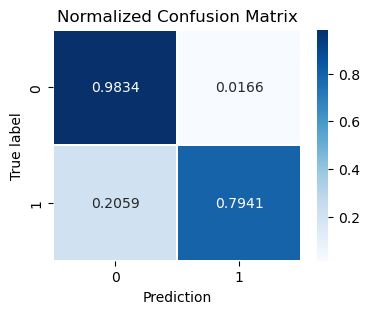

In [162]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'logistic-all_features')

Accuracy: 0.9740
F2-score: 0.7418
Recall:   0.7941



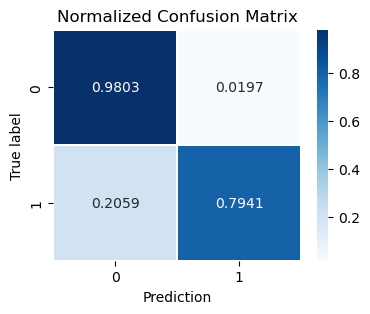

In [163]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'logistic-reduced_features')

# Ridge classifier

In [164]:
classifier = RidgeClassifier(solver='svd', alpha=5, random_state=0)

Accuracy: 0.9870
F2-score: 0.7988
Recall:   0.7941



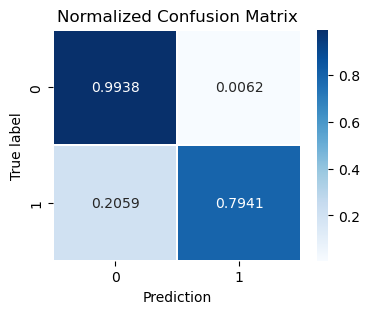

In [165]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'ridge-all_features')

Accuracy: 0.9740
F2-score: 0.7418
Recall:   0.7941



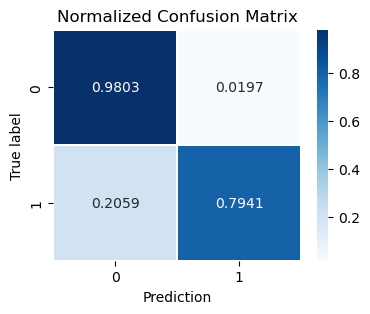

In [166]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'ridge-reduced_features')

# Passive Aggressive Classifier

In [167]:
classifier = PassiveAggressiveClassifier(
    C=0.1, early_stopping=True, tol=5e-4, n_iter_no_change=10, random_state=0)

Accuracy: 0.9830
F2-score: 0.7396
Recall:   0.7353



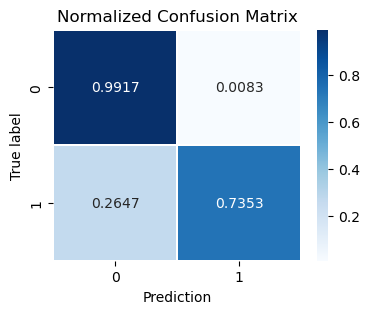

In [168]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'passive_aggressive-all_features')

Accuracy: 0.9520
F2-score: 0.6618
Recall:   0.7941



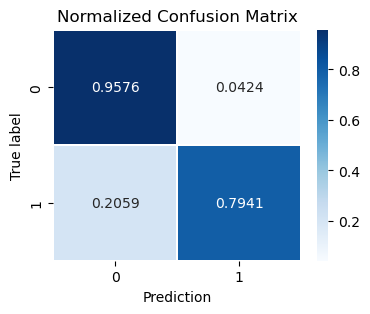

In [169]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'passive_aggressive-reduced_features')

# Perceptron

In [170]:
classifier = Perceptron(
    eta0=0.1, early_stopping=True, tol=5e-4, n_iter_no_change=10, random_state=0)

Accuracy: 0.9780
F2-score: 0.4605
Recall:   0.4118



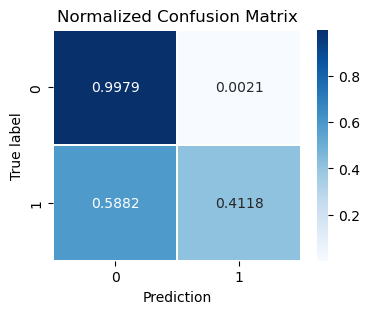

In [171]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'perceptron-all_features')

Accuracy: 0.9550
F2-score: 0.6345
Recall:   0.7353



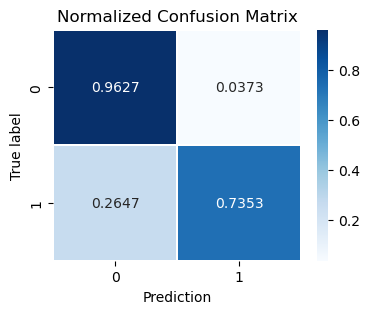

In [172]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'perceptron-reduced_features')